In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class IDCardProcessor:
    def __init__(self, img_size=(512, 512)):
        self.img_size = img_size

    def build_classifier(self):
        """Build a lightweight CNN for binary classification"""
        inputs = layers.Input(shape=(*self.img_size, 3))

        # First conv block
        x = layers.Conv2D(32, 3, activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)

        # Second conv block
        x = layers.Conv2D(64, 3, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)

        # Third conv block
        x = layers.Conv2D(128, 3, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)

        # Dense layers
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dropout(0.7)(x)
        outputs = layers.Dense(1, activation='sigmoid')(x)

        model = models.Model(inputs=inputs, outputs=outputs)

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

    def build_segmentation_model(self):
        """Build U-Net model for segmentation"""
        def conv_block(x, filters):
            x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
            x = layers.BatchNormalization()(x)
            return x

        inputs = layers.Input(shape=(*self.img_size, 3))

        # Encoder
        conv1 = conv_block(inputs, 64)
        pool1 = layers.MaxPooling2D()(conv1)

        conv2 = conv_block(pool1, 128)
        pool2 = layers.MaxPooling2D()(conv2)

        conv3 = conv_block(pool2, 256)
        pool3 = layers.MaxPooling2D()(conv3)

        # Bridge
        bridge = conv_block(pool3, 512)

        # Decoder
        up1 = layers.UpSampling2D()(bridge)
        up1 = layers.Concatenate()([up1, conv3])
        conv4 = conv_block(up1, 256)

        up2 = layers.UpSampling2D()(conv4)
        up2 = layers.Concatenate()([up2, conv2])
        conv5 = conv_block(up2, 128)

        up3 = layers.UpSampling2D()(conv5)
        up3 = layers.Concatenate()([up3, conv1])
        conv6 = conv_block(up3, 64)

        outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv6)

        model = models.Model(inputs, outputs)
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

    def create_data_generator(self, train_dir, test_dir, batch_size=32):
        """Create data generators for classification"""
        train_datagen = ImageDataGenerator(
            rescale=1.0/255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            fill_mode="nearest"
        )

        test_datagen = ImageDataGenerator(rescale=1.0/255)

        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=self.img_size,
            batch_size=batch_size,
            class_mode='binary'
        )

        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=self.img_size,
            batch_size=batch_size,
            class_mode='binary'
        )

        return train_generator, test_generator

    def train_classifier(self, base_path, epochs=10, batch_size=32):
        """Train the classification model"""
        train_dir = os.path.join(base_path, '1_classification', 'Train')
        test_dir = os.path.join(base_path, '1_classification', 'Test')

        train_generator, test_generator = self.create_data_generator(
            train_dir, test_dir, batch_size
        )

        model = self.build_classifier()

        callbacks_list = [
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=2,
                restore_best_weights=True
            ),
            callbacks.ModelCheckpoint(
                '/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/Saved Models/best_classifier_model.keras',
                save_best_only=True
            )
        ]

        history = model.fit(
            train_generator,
            validation_data=test_generator,
            epochs=epochs,
            callbacks=callbacks_list
        )

        return model

    def train_segmentation(self, base_path, epochs=10, batch_size=4):
        """Train the segmentation model with validation data"""

        # Directories for training and validation data
        train_image_dir = os.path.join(base_path, '2_segmentation', 'Train', 'Ids')
        train_mask_dir = os.path.join(base_path, '2_segmentation', 'Train', 'GroundTruth')
        val_image_dir = os.path.join(base_path, '2_segmentation', 'Test', 'Ids')
        val_mask_dir = os.path.join(base_path, '2_segmentation', 'Test', 'GroundTruth')

        # Load training data
        train_image_files = sorted([os.path.join(train_image_dir, f) for f in os.listdir(train_image_dir) if f.endswith('.png')])
        train_mask_files = sorted([os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir) if f.endswith('.png')])

        # Load validation data
        val_image_files = sorted([os.path.join(val_image_dir, f) for f in os.listdir(val_image_dir) if f.endswith('.png')])
        val_mask_files = sorted([os.path.join(val_mask_dir, f) for f in os.listdir(val_mask_dir) if f.endswith('.png')])

        def load_data(img_path, mask_path):
            img = tf.io.read_file(img_path)
            img = tf.image.decode_png(img, channels=3)
            img = tf.image.resize(img, self.img_size)
            img = img / 255.0

            mask = tf.io.read_file(mask_path)
            mask = tf.image.decode_png(mask, channels=1)
            mask = tf.image.resize(mask, self.img_size)
            mask = mask / 255.0

            return img, mask

        # Create training dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((train_image_files, train_mask_files))
        train_dataset = train_dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
        train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

        # Create validation dataset
        val_dataset = tf.data.Dataset.from_tensor_slices((val_image_files, val_mask_files))
        val_dataset = val_dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
        val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

        # Build and compile the segmentation model
        model = self.build_segmentation_model()

        # Define callbacks
        callbacks_list = [
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=2,
                restore_best_weights=True
            ),
            callbacks.ModelCheckpoint(
                '/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/Saved Models/best_segmentation_model.keras',
                monitor='val_loss',
                save_best_only=True
            )
        ]

        # Train the model
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs,
            callbacks=callbacks_list
        )

        return model



if __name__ == "__main__":
    base_path = "/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation"

    processor = IDCardProcessor()

    print("Training the classifier...")
    classifier_model = processor.train_classifier(base_path, epochs=10, batch_size=32)

    print("Training the segmentation model...")
    segmentation_model = processor.train_segmentation(base_path, epochs=10, batch_size=4)

    print("Training completed!")


Training the classifier...
Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 791s 25s/step - accuracy: 0.7452 - loss: 0.5340 - val_accuracy: 0.4900 - val_loss: 0.6982
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.9060 - loss: 0.2652 - val_accuracy: 0.5150 - val_loss: 0.7210
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.9515 - loss: 0.1543 - val_accuracy: 0.5000 - val_loss: 0.7781
Training the segmentation model...
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 526ms/step - accuracy: 0.9137 - loss: 0.3088 - val_accuracy: 0.8967 - val_loss: 0.2910
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.9831 - loss: 0.0778 - val_accuracy: 0.8882 - val_loss: 0.5591
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.9874 - loss: 0.0471 - val_accuracy: 0.8882 - val_loss: 0.5972
Training completed!


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
from PIL import Image
import cv2

class IDCardProcessor:
    def __init__(self, img_size=(512, 512)):
        self.img_size = img_size

    def build_classifier(self):
        """Build a lightweight CNN for binary classification"""
        model = models.Sequential([
            # First conv block
            layers.Conv2D(32, 3, activation='relu', input_shape=(*self.img_size, 3)),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),

            # Second conv block
            layers.Conv2D(64, 3, activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),

            # Third conv block
            layers.Conv2D(128, 3, activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),

            # Dense layers
            layers.GlobalAveragePooling2D(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

    def build_segmentation_model(self):
        """Build U-Net model for segmentation"""
        def conv_block(x, filters):
            x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
            x = layers.BatchNormalization()(x)
            return x

        # Input
        inputs = layers.Input(shape=(*self.img_size, 3))

        # Encoder
        conv1 = conv_block(inputs, 64)
        pool1 = layers.MaxPooling2D()(conv1)

        conv2 = conv_block(pool1, 128)
        pool2 = layers.MaxPooling2D()(conv2)

        conv3 = conv_block(pool2, 256)
        pool3 = layers.MaxPooling2D()(conv3)

        # Bridge
        bridge = conv_block(pool3, 512)

        # Decoder
        up1 = layers.UpSampling2D()(bridge)
        up1 = layers.Concatenate()([up1, conv3])
        conv4 = conv_block(up1, 256)

        up2 = layers.UpSampling2D()(conv4)
        up2 = layers.Concatenate()([up2, conv2])
        conv5 = conv_block(up2, 128)

        up3 = layers.UpSampling2D()(conv5)
        up3 = layers.Concatenate()([up3, conv1])
        conv6 = conv_block(up3, 64)

        # Output
        outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv6)

        model = models.Model(inputs, outputs)
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

    def create_data_generator(self, train_dir, test_dir, batch_size=32):
        """Create data generators for training and testing"""
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255
        )

        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=self.img_size,
            batch_size=batch_size,
            class_mode='binary'
        )

        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=self.img_size,
            batch_size=batch_size,
            class_mode='binary'
        )

        return train_generator, test_generator

    def train_classifier(self, base_path, epochs=10, batch_size=32):
        """Train the classification model"""
        train_dir = os.path.join(base_path, '1_classification', 'Train')
        test_dir = os.path.join(base_path, '1_classification', 'Test')

        train_generator, test_generator = self.create_data_generator(
            train_dir,
            test_dir,
            batch_size
        )

        model = self.build_classifier()

        history = model.fit(
            train_generator,
            validation_data=test_generator,
            epochs=epochs,
            steps_per_epoch=train_generator.samples // batch_size,
            validation_steps=test_generator.samples // batch_size
        )

        model.save('/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/Saved Models/id_classifier.keras')
        return history, model

    def create_segmentation_generators(self, images_dir, masks_dir, batch_size):
        """Create generator for segmentation data"""
        image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.png')])
        mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith('.png')])

        while True:
            # Shuffle the data
            indices = np.random.permutation(len(image_files))

            for i in range(0, len(indices), batch_size):
                batch_indices = indices[i:i + batch_size]
                batch_images = []
                batch_masks = []

                for idx in batch_indices:
                    # Load and preprocess image
                    img_path = os.path.join(images_dir, image_files[idx])
                    img = tf.keras.preprocessing.image.load_img(
                        img_path,
                        target_size=self.img_size
                    )
                    img = tf.keras.preprocessing.image.img_to_array(img) / 255.0

                    # Load and preprocess mask
                    mask_path = os.path.join(masks_dir, mask_files[idx])
                    mask = tf.keras.preprocessing.image.load_img(
                        mask_path,
                        target_size=self.img_size,
                        color_mode='grayscale'
                    )
                    mask = tf.keras.preprocessing.image.img_to_array(mask) / 255.0

                    batch_images.append(img)
                    batch_masks.append(mask)

                yield np.array(batch_images), np.array(batch_masks)

    def train_segmentation(self, base_path, epochs=10, batch_size=4):
        """Train the segmentation model"""
        train_images_dir = os.path.join(base_path, '2_segmentation', 'Train', 'Ids')
        train_masks_dir = os.path.join(base_path, '2_segmentation', 'Train', 'GroundTruth')

        train_generator = self.create_segmentation_generators(
            train_images_dir,
            train_masks_dir,
            batch_size
        )

        model = self.build_segmentation_model()

        steps_per_epoch = len(os.listdir(train_images_dir)) // batch_size

        history = model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs
        )

        model.save('/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/Saved Models/id_segmentation.keras')
        return history, model

# Example usage
if __name__ == "__main__":
    # Base path to your dataset
    base_path = "/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation"

    # Initialize the processor
    processor = IDCardProcessor()

    # Train classification model
    print("Training classification model...")
    class_history, class_model = processor.train_classifier(base_path)
    print("Classification model training completed!")

    # Train segmentation model
    print("Training segmentation model...")
    seg_history, seg_model = processor.train_segmentation(base_path)
    print("Segmentation model training completed!")

    # Print the classification model summary
    print("\nClassification Model Summary:")
    class_model.summary()

    # Print the segmentation model summary
    print("\nSegmentation Model Summary:")
    seg_model.summary()

Training classification model...
Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 797s 32s/step - accuracy: 0.7602 - loss: 0.4978 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.9421 - loss: 0.1565 - val_accuracy: 0.5052 - val_loss: 0.6822
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.9526 - loss: 0.1335 - val_accuracy: 0.5260 - val_loss: 0.6748
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.9751 - loss: 0.0682 - val_accuracy: 0.5104 - val_loss: 0.8537
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.9739 - loss: 0.0797 - val_accuracy: 0.6615 - val_loss: 0.6493
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.9465 - loss: 0.1467 - val_accuracy: 0.5260 - val_loss: 0.8088
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.9882 - loss: 0.0452 - val_accuracy: 0.6510 - val_loss: 0.5610
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.9927 - loss: 0.0268 - val_accuracy: 0.5000 - val_los

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 510, 510, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 510, 510, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 255, 255, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 253, 253, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 253, 253, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 126, 126, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 124, 124, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 124, 124, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 306,501 (1.17 MB)

 Trainable params: 102,017 (398.50 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 204,036 (797.02 KB)


Segmentation Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 512, 512, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 512, 512, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 512, 512, 64)   │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 256, 256, 64)   │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 256, 256, 128)  │            512 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 256, 256, 128)  │        147,584 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 256, 256, 128)  │            512 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 128)  │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 256)  │        295,168 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 128, 128, 256)  │          1,024 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 128, 128, 256)  │        590,080 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 128, 128, 256)  │          1,024 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 23,371,269 (89.15 MB)

 Trainable params: 7,788,545 (29.71 MB)

 Non-trainable params: 5,632 (22.00 KB)

 Optimizer params: 15,577,092 (59.42 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


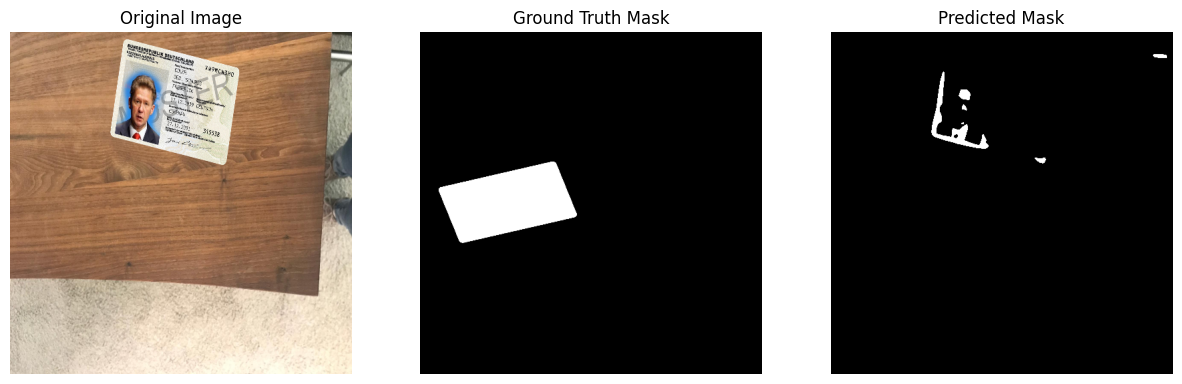

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_segmentation(image, ground_truth, predicted_mask):
    """
    Visualizes the original image, ground truth mask, and predicted mask.

    Args:
        image (numpy array): The input image.
        ground_truth (numpy array): The ground truth mask.
        predicted_mask (numpy array): The predicted mask from the model.
    """
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(ground_truth.squeeze(), cmap="gray")
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask.squeeze(), cmap="gray")
    plt.axis('off')

    plt.show()

# Example usage with one test sample
def evaluate_and_visualize_segmentation(model, image_path, mask_path, img_size):
    """
    Loads a test image and ground truth mask, predicts the segmentation mask,
    and visualizes the results.

    Args:
        model: Trained segmentation model.
        image_path (str): Path to the input test image.
        mask_path (str): Path to the ground truth mask.
        img_size (tuple): Size to resize the images for model input.
    """
    # Load the test image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255.0  # Normalize
    img_np = img.numpy()

    # Load the ground truth mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, img_size)
    mask = mask / 255.0  # Normalize
    mask_np = mask.numpy()

    # Predict the mask
    img_input = tf.expand_dims(img, axis=0)  # Add batch dimension
    predicted_mask = model.predict(img_input)
    predicted_mask = (predicted_mask > 0.5).astype(np.float32)  # Thresholding

    # Visualize
    visualize_segmentation(img_np, mask_np, predicted_mask[0])

# Example paths
image_path = "/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/1_classification/Test/Ids/fake_id_201__front.png"
mask_path = "/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/2_segmentation/Test/GroundTruth/fake_id_201__front_seg.png"
img_size = (512, 512)

# Visualize segmentation results
evaluate_and_visualize_segmentation(segmentation_model, image_path, mask_path, img_size)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step


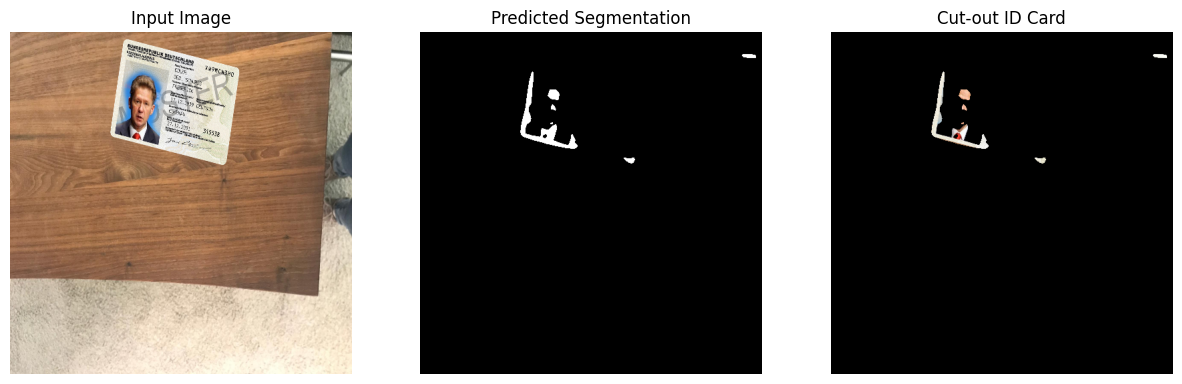

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

def visualize_results(image_path, mask_path, model, img_size):
    """
    Visualizes input image, predicted segmentation, and cut-out ID card.

    Args:
        image_path (str): Path to the input image.
        mask_path (str): Path to the ground truth mask.
        model: Trained segmentation model.
        img_size (tuple): Image size for resizing (e.g., (512, 512)).
    """
    # Load the input image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, img_size)
    img_normalized = img / 255.0  # Normalize
    img_np = img.numpy().astype(np.uint8)  # Convert to NumPy array for visualization

    # Predict the mask
    img_input = tf.expand_dims(img_normalized, axis=0)  # Add batch dimension
    predicted_mask = model.predict(img_input)
    predicted_mask = (predicted_mask[0] > 0.5).astype(np.uint8)  # Threshold to binary

    # Ensure the mask is single-channel and matches the input image size
    predicted_mask_resized = cv2.resize(predicted_mask, (img_np.shape[1], img_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Cut-out ID card from the original image
    cutout = cv2.bitwise_and(img_np, img_np, mask=predicted_mask_resized)

    # Load ground truth mask for comparison
    gt_mask = tf.io.read_file(mask_path)
    gt_mask = tf.image.decode_png(gt_mask, channels=1)
    gt_mask = tf.image.resize(gt_mask, img_size)
    gt_mask = gt_mask.numpy().astype(np.uint8)

    # Plot results
    plt.figure(figsize=(15, 5))

    # Input Image
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(img_np)
    plt.axis('off')

    # Predicted Segmentation
    plt.subplot(1, 3, 2)
    plt.title("Predicted Segmentation")
    plt.imshow(predicted_mask_resized, cmap='gray')
    plt.axis('off')

    # Cut-out ID Card
    plt.subplot(1, 3, 3)
    plt.title("Cut-out ID Card")
    plt.imshow(cutout)
    plt.axis('off')

    plt.show()


# Load the saved segmentation model
saved_model_path = "/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/Saved Models/best_segmentation_model.keras"
segmentation_model = load_model(saved_model_path)



# Example Usage
image_path = "/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/1_classification/Test/Ids/fake_id_201__front.png"
mask_path = "/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/2_segmentation/Test/GroundTruth/fake_id_201__front_seg.png"
img_size = (512, 512)  # Image size used in training

# Call the visualization function
visualize_results(image_path, mask_path, segmentation_model, img_size)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


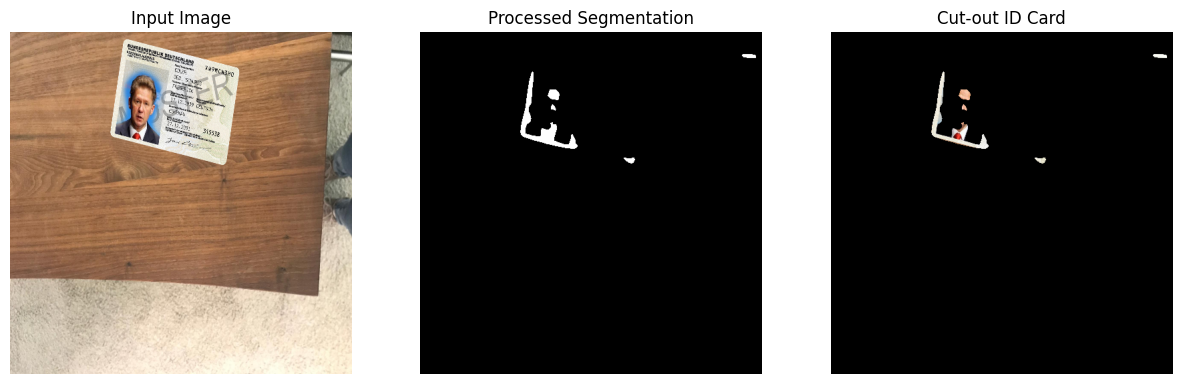

In [ ]:
def visualize_results_with_post_processing(image_path, mask_path, model, img_size):
    """
    Visualizes input image, predicted segmentation, and cut-out ID card with post-processing.

    Args:
        image_path (str): Path to the input image.
        mask_path (str): Path to the ground truth mask.
        model: Trained segmentation model.
        img_size (tuple): Image size for resizing (e.g., (512, 512)).
    """
    # Load the input image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, img_size)
    img_normalized = img / 255.0  # Normalize
    img_np = img.numpy().astype(np.uint8)  # Convert to NumPy array for visualization

    # Predict the mask
    img_input = tf.expand_dims(img_normalized, axis=0)  # Add batch dimension
    predicted_mask = model.predict(img_input)
    predicted_mask = (predicted_mask[0] > 0.5).astype(np.uint8)  # Threshold to binary

    # Post-process the predicted mask
    kernel = np.ones((5, 5), np.uint8)
    processed_mask = cv2.morphologyEx(predicted_mask, cv2.MORPH_CLOSE, kernel)

    # Ensure the mask matches the input image size
    processed_mask_resized = cv2.resize(processed_mask, (img_np.shape[1], img_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Cut-out ID card from the original image
    cutout = cv2.bitwise_and(img_np, img_np, mask=processed_mask_resized)

    # Plot results
    plt.figure(figsize=(15, 5))

    # Input Image
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(img_np)
    plt.axis('off')

    # Predicted Segmentation (Post-Processed)
    plt.subplot(1, 3, 2)
    plt.title("Processed Segmentation")
    plt.imshow(processed_mask_resized, cmap='gray')
    plt.axis('off')

    # Cut-out ID Card
    plt.subplot(1, 3, 3)
    plt.title("Cut-out ID Card")
    plt.imshow(cutout)
    plt.axis('off')

    plt.show()


# Call the improved visualization function
visualize_results_with_post_processing(image_path, mask_path, segmentation_model, img_size)


**Code for Task 3: De-Skewing**

In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

class Deskewer:
    def __init__(self):
        self.input_folder = "/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/3_deskewing/originals/"
        self.output_folder = "/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/3_deskewing/deskewed/"
        os.makedirs(self.output_folder, exist_ok=True)

    def hough_transform_deskew(self, image_path):
        """
        Deskews an image using Hough Transform to detect dominant lines.
        """
        # Load the image
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Apply edge detection
        edges = cv2.Canny(img, 50, 150, apertureSize=3)

        # Apply Hough Line Transform
        lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
        if lines is not None:
            # Compute the average angle of detected lines
            angles = []
            for rho, theta in lines[:, 0]:
                angle = (theta - np.pi / 2) * 180 / np.pi
                angles.append(angle)
            mean_angle = np.mean(angles)

            # Rotate the image to deskew
            (h, w) = img.shape
            center = (w // 2, h // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, mean_angle, 1.0)
            deskewed_img = cv2.warpAffine(img, rotation_matrix, (w, h))
            return deskewed_img, mean_angle
        else:
            print("No lines detected for deskewing.")
            return img, 0

    def sift_feature_matching_deskew(self, image_path, ref_image_path):
        """
        Deskews an image using SIFT feature matching to compute homography.
        """
        # Load the images
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        ref_img = cv2.imread(ref_image_path, cv2.IMREAD_GRAYSCALE)

        # Detect SIFT features and compute descriptors
        sift = cv2.SIFT_create()
        keypoints1, descriptors1 = sift.detectAndCompute(img, None)
        keypoints2, descriptors2 = sift.detectAndCompute(ref_img, None)

        # Match features using BFMatcher
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(descriptors1, descriptors2, k=2)

        # Apply Lowe's ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)

        if len(good_matches) > 4:
            # Compute homography matrix
            src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            homography, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # Apply the homography to deskew the image
            deskewed_img = cv2.warpPerspective(img, homography, (ref_img.shape[1], ref_img.shape[0]))
            return deskewed_img
        else:
            print("Not enough good matches for deskewing.")
            return img

    def process_images(self, method="hough", ref_image_path=None):
        """
        Deskews all images in the input folder and saves the results.
        Args:
            method (str): 'hough' or 'sift'
            ref_image_path (str): Reference image for SIFT method (required for SIFT).
        """
        for filename in os.listdir(self.input_folder):
            image_path = os.path.join(self.input_folder, filename)
            if method == "hough":
                deskewed_img, angle = self.hough_transform_deskew(image_path)
                print(f"{filename}: Deskewed using Hough Transform with angle {angle:.2f}°")
            elif method == "sift" and ref_image_path is not None:
                deskewed_img = self.sift_feature_matching_deskew(image_path, ref_image_path)
                print(f"{filename}: Deskewed using SIFT Feature Matching")
            else:
                print("Invalid method or missing reference image for SIFT.")
                continue

            # Save the deskewed image
            output_path = os.path.join(self.output_folder, filename)
            cv2.imwrite(output_path, deskewed_img)

    def visualize_deskewing(self, image_path, deskewed_img, angle=0):
        """
        Visualizes the original and deskewed images side-by-side.
        """
        original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(original_img, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title(f"Deskewed Image (Angle: {angle:.2f}°)")
        plt.imshow(deskewed_img, cmap="gray")
        plt.axis("off")

        plt.show()


# Example Usage
if __name__ == "__main__":
    deskewer = Deskewer()

    # Deskew using Hough Transform
    deskewer.process_images(method="hough")

    # Deskew using SIFT Feature Matching (requires a reference image)
    reference_image = "/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/3_deskewing/reference.png"
    deskewer.process_images(method="sift", ref_image_path=reference_image)


fake_id_44__front.png: Deskewed using Hough Transform with angle -6.16°
fake_id_49__front.png: Deskewed using Hough Transform with angle -4.94°
fake_id_42_back.png: Deskewed using Hough Transform with angle -4.08°
fake_id_15__front.png: Deskewed using Hough Transform with angle -4.90°
fake_id_22_back.png: Deskewed using Hough Transform with angle -3.47°
fake_id_30__front.png: Deskewed using Hough Transform with angle 0.50°
fake_id_36_back.png: Deskewed using Hough Transform with angle -5.33°
fake_id_6__front.png: Deskewed using Hough Transform with angle -0.85°
fake_id_39_back.png: Deskewed using Hough Transform with angle -4.07°
fake_id_27__front.png: Deskewed using Hough Transform with angle -2.38°
fake_id_35_back.png: Deskewed using Hough Transform with angle -5.46°
fake_id_17_back.png: Deskewed using Hough Transform with angle 1.91°
fake_id_34_back.png: Deskewed using Hough Transform with angle -6.42°
fake_id_25_back.png: Deskewed using Hough Transform with angle -3.56°
fake_id_38_

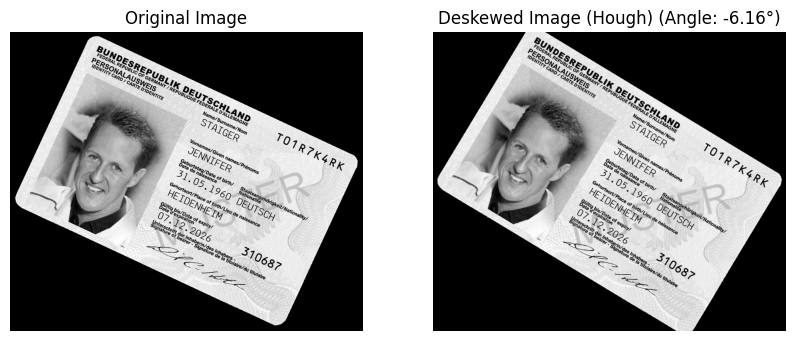

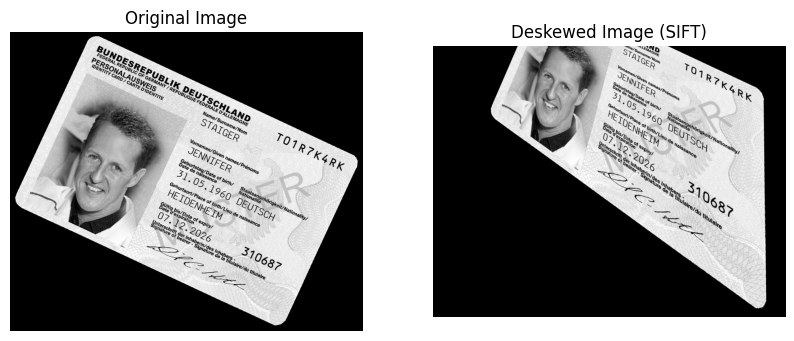

In [ ]:
def visualize_deskewing(image_path, deskewed_img, angle=None, method="Hough"):
    """
    Visualizes the original and deskewed images side-by-side.

    Args:
        image_path (str): Path to the original image.
        deskewed_img (numpy array): Deskewed image.
        angle (float): Deskewing angle (if using Hough Transform).
        method (str): Method used for deskewing ("Hough" or "SIFT").
    """
    original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    title = f"Deskewed Image ({method})"
    if angle is not None:
        title += f" (Angle: {angle:.2f}°)"
    plt.title(title)
    plt.imshow(deskewed_img, cmap="gray")
    plt.axis("off")

    plt.show()

# Create an instance of the Deskewer class
deskewer = Deskewer()

# Path to an example input image
example_image_path = "/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/3_deskewing/originals/fake_id_44__front.png"

# Path to the reference image for SIFT (optional, required for SIFT method)
reference_image_path = "/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/3_deskewing/reference.png"

# Visualize Hough Transform Deskewing
deskewed_img_hough, angle_hough = deskewer.hough_transform_deskew(example_image_path)
visualize_deskewing(example_image_path, deskewed_img_hough, angle=angle_hough, method="Hough")

# Visualize SIFT Feature Matching Deskewing
if os.path.exists(reference_image_path):  # Ensure reference image exists
    deskewed_img_sift = deskewer.sift_feature_matching_deskew(example_image_path, reference_image_path)
    visualize_deskewing(example_image_path, deskewed_img_sift, method="SIFT")
else:
    print("Reference image for SIFT method is missing!")


**Code for Task 4: Cleaning**

Training the cleaning model...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 512, 512, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_56    │ (None, 512, 512, 64)   │            256 │ conv2d_58[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_56             │ (None, 512, 512, 64)   │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 512, 512, 64)   │         36,928 │ activation_56[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_57    │ (None, 512, 512, 64)   │            256 │ conv2d_59[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 512, 512, 64)   │            256 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_57             │ (None, 512, 512, 64)   │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_58    │ (None, 512, 512, 64)   │            256 │ conv2d_60[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (None, 512, 512, 64)   │              0 │ activation_57[0][0],   │
│                           │                        │                │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_58             │ (None, 512, 512, 64)   │              0 │ add_18[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 256, 256, 64)   │              0 │ activation_58[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_59    │ (None, 256, 256, 128)  │            512 │ conv2d_61[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_59        

 Total params: 33,195,393 (126.63 MB)

 Trainable params: 33,177,601 (126.56 MB)

 Non-trainable params: 17,792 (69.50 KB)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9171 - io_u_2: 0.0000e+00 - loss: 0.3650 - precision: 0.9994 - recall: 0.9371 - val_accuracy: 0.9526 - val_io_u_2: 0.0000e+00 - val_loss: 0.2024 - val_precision: 0.9922 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.9573 - io_u_2: 0.0000e+00 - loss: 0.0825 - precision: 1.0000 - recall: 0.9803 - val_accuracy: 0.9526 - val_io_u_2: 0.0000e+00 - val_loss: 0.1300 - val_precision: 0.9922 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.9577 - io_u_2: 0.0000e+00 - loss: 0.0538 - precision: 1.0000 - recall: 0.9804 - val_accuracy: 0.9526 - val_io_u_2: 0.0000e+00 - val_loss: 0.1099 - val_precision: 0.9922 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.9590 - io_u_2: 0.0000e+00 - loss: 0.0415 - precision: 1.0000 - recall: 0.9808 - val_ac

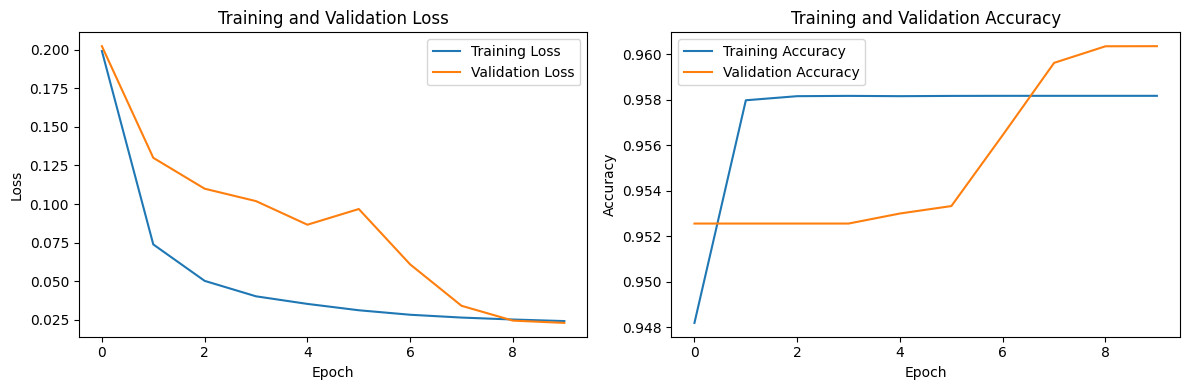


Visualizing results...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


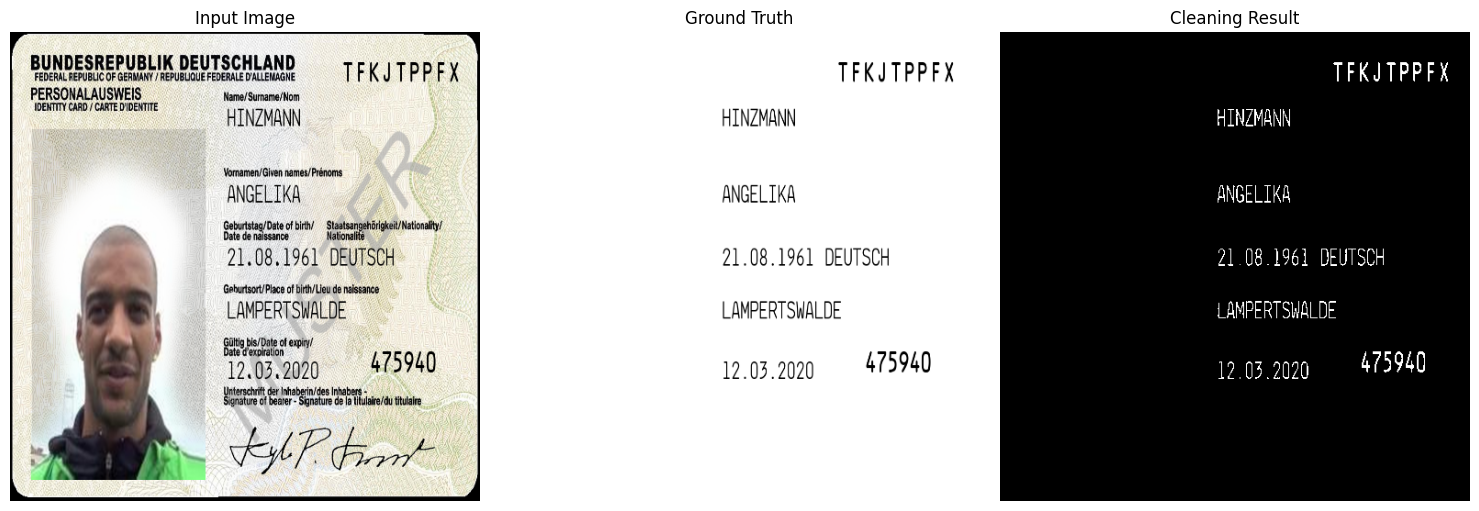

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


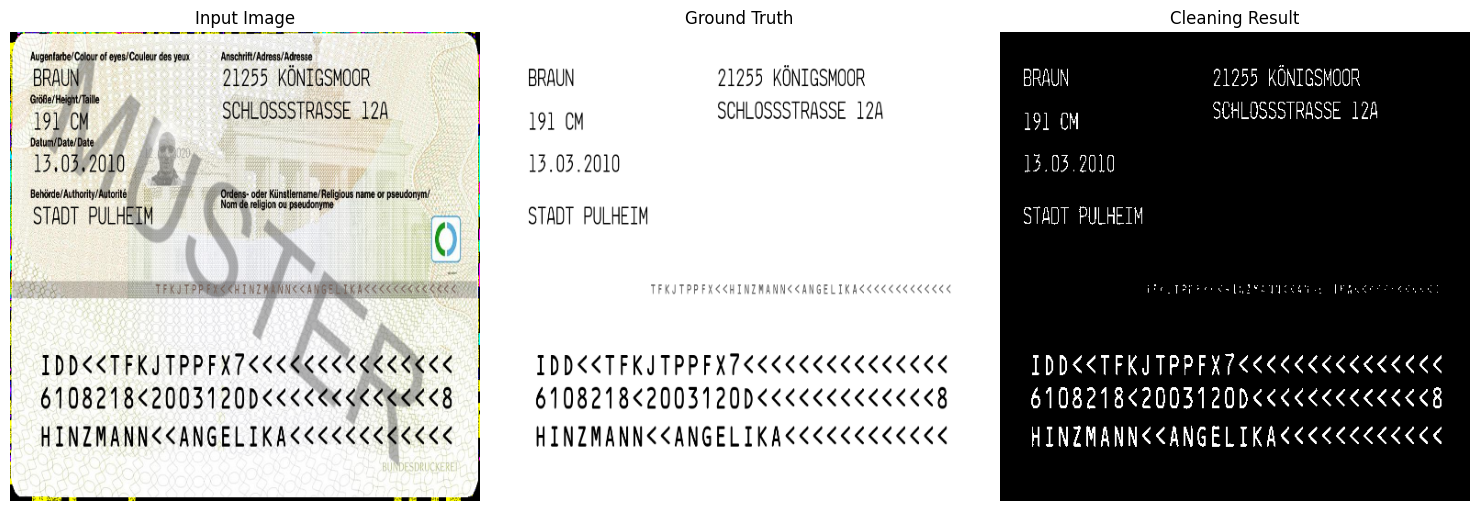

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


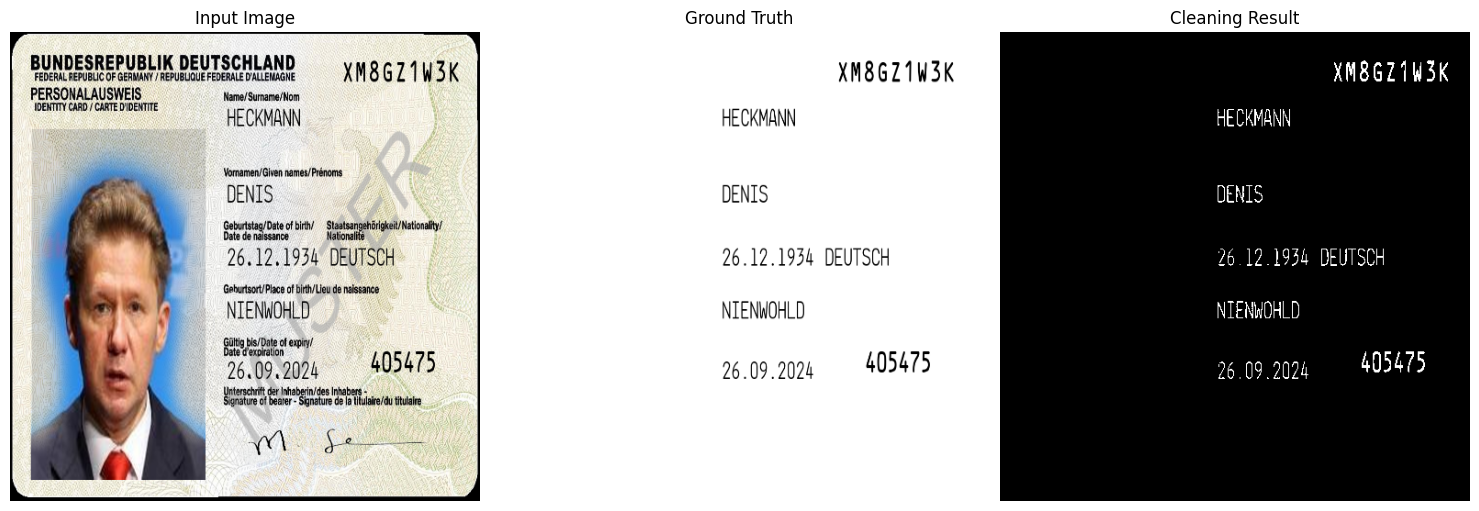

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


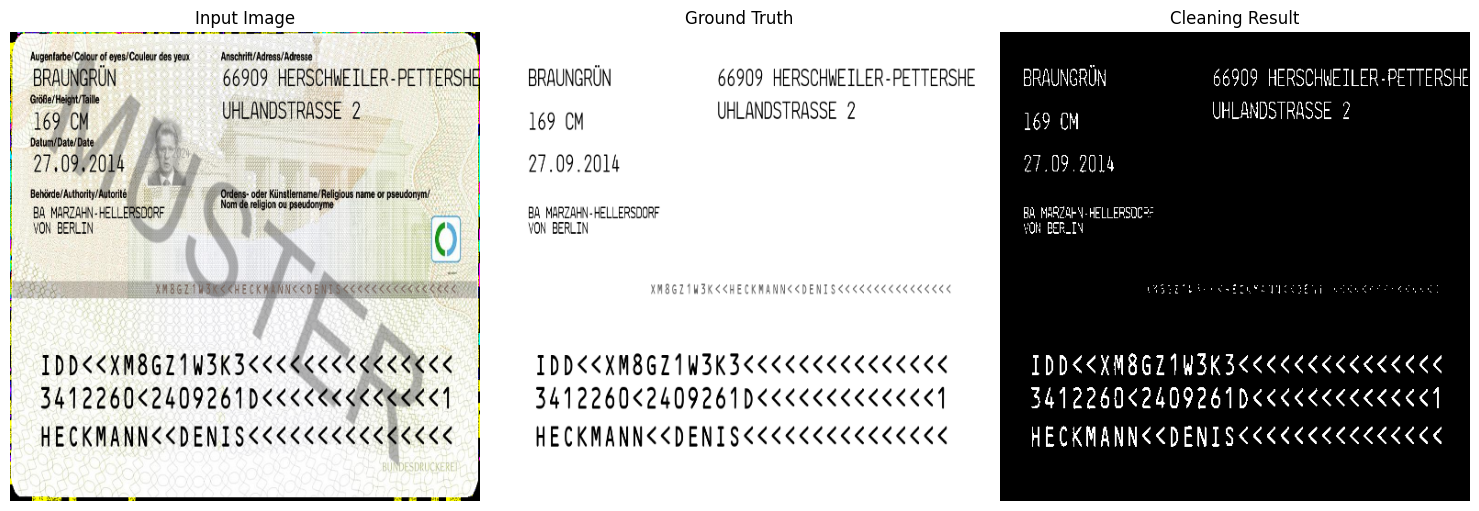

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

class ImageCleaner:
    def __init__(self, img_size=(512, 512)):
        self.img_size = img_size
        self.train_image_dir = "/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/4_cleaning/Train/Ids"
        self.train_mask_dir = "/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/4_cleaning/Train/GroundTruth"
        self.test_image_dir = "/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/4_cleaning/Test/Ids"
        self.test_mask_dir = "/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/4_cleaning/Test/GroundTruth"


    def load_images_and_masks(self, img_dir, mask_dir):
        """Load images and their corresponding masks with improved preprocessing."""
        img_files = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.png')])
        mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

        images = []
        masks = []
        for img_file, mask_file in zip(img_files, mask_files):
            # Load and preprocess image
            img = tf.io.read_file(img_file)
            img = tf.image.decode_png(img, channels=3)
            img = tf.image.resize(img, self.img_size)
            # Convert to grayscale and normalize
            img_gray = tf.image.rgb_to_grayscale(img)
            img = tf.cast(img, tf.float32) / 255.0

            # Load and preprocess mask
            mask = tf.io.read_file(mask_file)
            mask = tf.image.decode_png(mask, channels=1)
            mask = tf.image.resize(mask, self.img_size)
            mask = tf.cast(mask, tf.float32)
            # Normalize mask without binary threshold
            mask = mask / 255.0

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def weighted_bce_loss(self, y_true, y_pred):
        """Weighted binary crossentropy loss to handle class imbalance"""
        epsilon = 1e-7
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        # Calculate weights (give more importance to text pixels)
        weights = tf.where(y_true > 0.5, 2.0, 1.0)

        # Calculate binary crossentropy
        bce = y_true * tf.math.log(y_pred + epsilon) + (1 - y_true) * tf.math.log(1 - y_pred + epsilon)
        weighted_bce = -tf.reduce_mean(weights * bce)

        return weighted_bce

    def dice_loss(self, y_true, y_pred):
        """Modified Dice loss with adjusted weights"""
        smooth = 1e-6
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
        return 1 - dice

    def combined_loss(self, y_true, y_pred):
        """Weighted combination of BCE and Dice loss"""
        w_bce = self.weighted_bce_loss(y_true, y_pred)
        dice = self.dice_loss(y_true, y_pred)
        # Give more weight to BCE loss to preserve text details
        return 0.7 * w_bce + 0.3 * dice

    def build_model(self):
        """Build an improved U-Net model with residual connections"""
        def conv_block(x, filters, kernel_size=3):
            conv = layers.Conv2D(filters, kernel_size, padding='same')(x)
            conv = layers.BatchNormalization()(conv)
            conv = layers.Activation('relu')(conv)
            conv = layers.Conv2D(filters, kernel_size, padding='same')(conv)
            conv = layers.BatchNormalization()(conv)
            conv = layers.Activation('relu')(conv)
            return conv

        def residual_block(x, filters):
            """Residual block with skip connection"""
            conv = conv_block(x, filters)
            shortcut = layers.Conv2D(filters, 1, padding='same')(x)
            shortcut = layers.BatchNormalization()(shortcut)
            output = layers.Add()([conv, shortcut])
            return layers.Activation('relu')(output)

        # Input
        inputs = layers.Input(shape=(*self.img_size, 3))

        # Encoder
        enc1 = residual_block(inputs, 64)
        pool1 = layers.MaxPooling2D(pool_size=(2, 2))(enc1)

        enc2 = residual_block(pool1, 128)
        pool2 = layers.MaxPooling2D(pool_size=(2, 2))(enc2)

        enc3 = residual_block(pool2, 256)
        pool3 = layers.MaxPooling2D(pool_size=(2, 2))(enc3)

        enc4 = residual_block(pool3, 512)
        pool4 = layers.MaxPooling2D(pool_size=(2, 2))(enc4)

        # Bridge
        bridge = residual_block(pool4, 1024)

        # Decoder with skip connections
        up1 = layers.UpSampling2D(size=(2, 2))(bridge)
        up1 = layers.Concatenate()([enc4, up1])
        dec1 = residual_block(up1, 512)

        up2 = layers.UpSampling2D(size=(2, 2))(dec1)
        up2 = layers.Concatenate()([enc3, up2])
        dec2 = residual_block(up2, 256)

        up3 = layers.UpSampling2D(size=(2, 2))(dec2)
        up3 = layers.Concatenate()([enc2, up3])
        dec3 = residual_block(up3, 128)

        up4 = layers.UpSampling2D(size=(2, 2))(dec3)
        up4 = layers.Concatenate()([enc1, up4])
        dec4 = residual_block(up4, 64)

        # Output with modified final layers
        conv_final = layers.Conv2D(64, 3, padding='same')(dec4)
        conv_final = layers.BatchNormalization()(conv_final)
        conv_final = layers.Activation('relu')(conv_final)
        outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv_final)

        model = models.Model(inputs=inputs, outputs=outputs)

        # Use a higher learning rate initially
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
            loss=self.combined_loss,
            metrics=['accuracy',
                    tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1]),
                    tf.keras.metrics.Recall(name='recall'),
                    tf.keras.metrics.Precision(name='precision')]
        )

        return model

    def train_model(self, epochs=10, batch_size=4):
        """Train the cleaning model with improved parameters."""
        # Load and prepare data
        train_images, train_masks = self.load_images_and_masks(self.train_image_dir, self.train_mask_dir)
        test_images, test_masks = self.load_images_and_masks(self.test_image_dir, self.test_mask_dir)

        # Split training data
        train_images, val_images, train_masks, val_masks = train_test_split(
            train_images, train_masks, test_size=0.2, random_state=42
        )

        # Data augmentation
        data_augmentation = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
        ])

        # Build and train model
        model = self.build_model()

        # Print model summary
        model.summary()

        # Callbacks
        callbacks_list = [
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.1,
                patience=3,
                min_lr=1e-6
            ),
            callbacks.ModelCheckpoint(
                'best_cleaning_model.keras',
                monitor='val_loss',
                save_best_only=True
            )
        ]

        # Train the model
        history = model.fit(
            train_images, train_masks,
            validation_data=(val_images, val_masks),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks_list
        )

        return model, history, (test_images, test_masks)

    def visualize_results(self, model, test_images, test_masks, num_samples=4):
        """Visualize the results with correct black text on white background format."""
        for i in range(min(num_samples, len(test_images))):
            img = test_images[i]
            mask = test_masks[i]
            pred_mask = model.predict(np.expand_dims(img, axis=0))[0]

            # Apply threshold to predicted mask
            pred_mask = (pred_mask > 0.5).astype(np.uint8)

            # Create a white background
            cleaned_img = np.ones(pred_mask.shape) * 1.0

            # For areas where mask is 1 (text to keep), set to black (0)
            cleaned_img[pred_mask.squeeze() > 0.5] = 0.0

            plt.figure(figsize=(15, 5))

            # Original Image
            plt.subplot(1, 3, 1)
            plt.title("Input Image")
            plt.imshow(img)
            plt.axis("off")

            # Ground Truth Mask
            plt.subplot(1, 3, 2)
            plt.title("Ground Truth")
            plt.imshow(mask.squeeze(), cmap='gray', vmin=0, vmax=1)
            plt.axis("off")

            # Cleaned Result
            plt.subplot(1, 3, 3)
            plt.title("Cleaning Result")
            plt.imshow(cleaned_img.squeeze(), cmap='gray', vmin=0, vmax=1)
            plt.axis("off")

            plt.tight_layout()
            plt.show()


# Run the cleaning task
if __name__ == "__main__":
    cleaner = ImageCleaner(img_size=(512, 512))

    print("Training the cleaning model...")
    model, history, (test_images, test_masks) = cleaner.train_model(epochs=10, batch_size=4)

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nVisualizing results...")
    cleaner.visualize_results(model, test_images, test_masks)

In [2]:
!sudo apt-get update
!sudo apt-get install tesseract-ocr
!pip install pytesseract

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,312 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,609 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,673 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadco

In [ ]:
import os
import json
from PIL import Image, ImageEnhance
import pytesseract

class IDCardOCR:
    def __init__(self, ocr_folder):
        """
        Initialize the OCR processor with the folder containing cleaned ID card images.

        Args:
            ocr_folder (str): Path to the folder with OCR images.
        """
        self.ocr_folder = ocr_folder

    def preprocess_image(self, image):
        """
        Preprocess the image to improve OCR accuracy.
        This function converts the image to grayscale and enhances its contrast.

        Args:
            image (PIL.Image): Input image.

        Returns:
            PIL.Image: Preprocessed image.
        """
        # Convert the image to grayscale
        gray_image = image.convert("L")
        # Enhance contrast
        enhancer = ImageEnhance.Contrast(gray_image)
        enhanced_image = enhancer.enhance(2.0)
        return enhanced_image

    def extract_text(self, image_path, preprocess=True):
        """
        Extract text from an image using Tesseract OCR.

        Args:
            image_path (str): Path to the image file.
            preprocess (bool): Whether to apply preprocessing to the image.

        Returns:
            str: The OCR-extracted text.
        """
        try:
            image = Image.open(image_path)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return ""

        if preprocess:
            image = self.preprocess_image(image)

        # Tesseract configuration:
        # --oem 3 : Default engine mode.
        # --psm 6 : Assume a uniform block of text.
        config = "--oem 3 --psm 6"
        extracted_text = pytesseract.image_to_string(image, config=config, lang="eng")
        return extracted_text

    def process_all_images(self):
        """
        Process all PNG images in the OCR folder.

        Returns:
            dict: A dictionary mapping each image filename to a list of recognized text lines.
        """
        ocr_results = {}
        for filename in os.listdir(self.ocr_folder):
            if filename.lower().endswith(".png"):
                image_path = os.path.join(self.ocr_folder, filename)
                text = self.extract_text(image_path, preprocess=True)
                # Split the recognized text into lines (preserving empty lines)
                lines = text.splitlines()
                ocr_results[filename] = lines
        return ocr_results

if __name__ == "__main__":
    # Set this path to your OCR folder (where your images like fake_id_20_back.png are stored)
    ocr_folder = "/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/5_ocr"

    ocr_processor = IDCardOCR(ocr_folder)
    results = ocr_processor.process_all_images()

    # Print the output as a JSON-formatted string
    print(json.dumps(results, indent=4))


{
    "fake_id_20_back.png": [
        "GRAU 17419 ZIRCHOW",
        "",
        "77 cM AM ANGER 71",
        "",
        "24.05.2017",
        "",
        "STADT CHEMNITZ",
        "VRENWKZ4L<<SCHLEICHER<<ELEONORE<<<<<<<<K<<<",
        "",
        "IDD<<VRENWKZ4L1<<<< <<< <<< KKK KK",
        "",
        "6810292<2705239D<<<<<<<s<<<<<",
        "",
        "SCHLEICHER<<ELEONORE<<<<<<<<<<",
        ""
    ],
    "fake_id_45_back.png": [
        "BLAU 66957 SCHWEIX",
        "",
        "162 CM DANZIGER STRASSE 11",
        "",
        "17.01.2011",
        "",
        "STADT SPRINGE",
        "LIN9168W5<<SELZER<<ANNE<X<<<< <<< << KKK KKK KKK",
        "",
        "IDD<<L1N9168W52<<<<<sssssssss<",
        "",
        "6707312<2101163D<<<<<<Ksessss5",
        "",
        "SELZER<<ANNE<<<<<<<sssesssssssy\u00a2",
        ""
    ],
    "fake_id_35__front.png": [
        "VYZ52X2MP",
        "WILLER",
        "GEB. SAUTTER",
        "LEO",
        "03.06.1935 DEUTSCH",
        "FREISBACH",
 

**END TO END PART:**

In [4]:
import os
import json
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import pytesseract
import tensorflow as tf

########################################
# Register the custom loss function for cleaning model loading
########################################
@tf.keras.utils.register_keras_serializable(package="Custom", name="method")
def combined_loss(y_true, y_pred):
    smooth = 1e-6
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice_loss = 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 0.7 * bce + 0.3 * dice_loss

########################################
# 1. Classification Step
########################################
def perform_classification(image_path,
                           model_path='/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/Saved Models/id_classifier.keras',
                           threshold=0.85):
    try:
        classifier = load_model(model_path)
    except Exception as e:
        print(f"Error loading classification model: {e}")
        return False

    image = load_img(image_path, target_size=(512, 512))
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    prediction = classifier.predict(image_array)
    score = prediction[0][0]
    is_id = (score < threshold)
    print(f"Classification for {os.path.basename(image_path)}: {'ID Card' if is_id else 'Not an ID Card'} (score: {score:.3f})")
    return is_id

########################################
# 2. Segmentation Step
########################################
def perform_segmentation(image_path,
                         model_path='/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/Saved Models/id_segmentation.keras',
                         target_size=(512, 512)):
    try:
        segmenter = load_model(model_path)
    except Exception as e:
        print(f"Error loading segmentation model: {e}")
        return None

    test_img = load_img(image_path, target_size=target_size)
    test_img_array = img_to_array(test_img) / 255.0
    test_img_array = np.expand_dims(test_img_array, axis=0)

    predicted_mask = segmenter.predict(test_img_array)
    threshold = 0.5
    predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

    contours, _ = cv2.findContours(predicted_mask_binary[0, :, :, 0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        orig_img = Image.open(image_path).resize(target_size)
        cropped_img = orig_img.crop((x, y, x+w, y+h))
        output_path = os.path.join("temp", os.path.splitext(os.path.basename(image_path))[0] + "_segmented.png")
        os.makedirs("temp", exist_ok=True)
        cropped_img.save(output_path)
        print(f"Segmentation successful: {output_path}")
        return output_path
    else:
        print(f"Segmentation failed: No contour found for {image_path}")
        return None

########################################
# 3. Deskewing Step
########################################
def perform_deskewing(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error reading image for deskewing: {image_path}")
        return None

    edges = cv2.Canny(img, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi/180, 200)
    if lines is not None:
        angles = [ (line[0][1] - np.pi/2) * 180/np.pi for line in lines ]
        mean_angle = np.mean(angles)
        (h, w) = img.shape
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, mean_angle, 1.0)
        deskewed = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        output_path = os.path.join("temp", os.path.splitext(os.path.basename(image_path))[0] + "_deskewed.png")
        cv2.imwrite(output_path, deskewed)
        print(f"Deskewing successful: {output_path} (angle: {mean_angle:.2f}°)")
        return output_path
    else:
        print(f"Deskewing skipped: No dominant lines detected in {image_path}")
        return image_path

########################################
# 4. Cleaning Step
########################################
def perform_cleaning(image_path,
                     model_path='/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/Saved Models/best_cleaning_model.keras',
                     target_size=(512, 512)):
    try:
        # Load the cleaning model using the custom loss registered under the key 'method'
        cleaner = load_model(model_path, custom_objects={'method': combined_loss})
    except Exception as e:
        print(f"Error loading cleaning model: {e}")
        return image_path  # If the cleaning model cannot be loaded, return the original image

    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict cleaned image
    cleaned = cleaner.predict(img_array)
    cleaned = np.squeeze(cleaned)

    # Check if the cleaned image is mostly white (values near 1)
    if np.mean(cleaned) > 0.8:
        print("Cleaning model output is mostly white, inverting image.")
        cleaned = 1 - cleaned

    # Scale to 0-255
    cleaned = (cleaned * 255).astype(np.uint8)
    # Normalize the image to enhance contrast
    cleaned = cv2.normalize(cleaned, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    output_path = os.path.join("temp", os.path.splitext(os.path.basename(image_path))[0] + "_cleaned.png")
    Image.fromarray(cleaned).save(output_path)
    print(f"Cleaning successful: {output_path}")
    return output_path


########################################
# NEW: Image Enhancement for OCR
########################################
def prepare_image_for_ocr(image_path):
    """
    Enhances the image for OCR by converting it to grayscale, applying histogram equalization,
    adaptive thresholding, and morphological closing to join broken text segments.

    Returns the path to the enhanced image.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error reading image for OCR enhancement: {image_path}")
        return image_path

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply histogram equalization to improve contrast
    equalized = cv2.equalizeHist(gray)

    # Apply adaptive thresholding
    # You might try adjusting the blockSize (11) or constant (2) if needed.
    thresh = cv2.adaptiveThreshold(equalized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)

    # Apply morphological closing to join broken text (using a 3x3 rectangular kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    output_path = os.path.join("temp", os.path.splitext(os.path.basename(image_path))[0] + "_ocr_ready.png")
    cv2.imwrite(output_path, closed)
    print(f"OCR enhancement complete: {output_path}")
    return output_path


########################################
# 5. OCR Step
########################################
def perform_ocr(image_path):
    # First, enhance the image for OCR
    ocr_ready_path = prepare_image_for_ocr(image_path)
    try:
        img = Image.open(ocr_ready_path)
    except Exception as e:
        print(f"Error opening image for OCR: {e}")
        return []
    # You can adjust Tesseract configuration if needed
    config = "--oem 3 --psm 6"
    text = pytesseract.image_to_string(img, config=config)
    print(f"OCR completed for {os.path.basename(image_path)}")
    return text.splitlines()

########################################
# End-to-End Pipeline Function
########################################
def end_to_end_pipeline(image_path):
    print(f"\nProcessing {os.path.basename(image_path)} ...")

    if not perform_classification(image_path):
        print(f"Skipping {os.path.basename(image_path)}: Not an ID card.")
        return None

    segmented_path = perform_segmentation(image_path)
    if segmented_path is None:
        print("Segmentation failed.")
        return None

    deskewed_path = perform_deskewing(segmented_path)
    if deskewed_path is None:
        print("Deskewing failed.")
        return None

    cleaned_path = perform_cleaning(deskewed_path)
    ocr_output = perform_ocr(cleaned_path)
    return ocr_output

########################################
# Main Function: Process a Test Directory
########################################
def main():
    test_image_directory = "/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/TestingPipeline/test_image"
    results = {}

    for filename in os.listdir(test_image_directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(test_image_directory, filename)
            ocr_lines = end_to_end_pipeline(image_path)
            if ocr_lines is not None:
                results[filename] = ocr_lines
            else:
                results[filename] = ["Processing failed or image was not an ID card."]

    output_json = "/content/drive/MyDrive/Important Documents/University Class Materials/winter 24 25/Image Processing for Document Automation/ocr_output/ocr_output.json"
    os.makedirs(os.path.dirname(output_json), exist_ok=True)
    with open(output_json, 'w') as json_file:
        json.dump(results, json_file, indent=4)

    print("\nEnd-to-end pipeline complete. Results saved to:", output_json)

if __name__ == "__main__":
    main()



Processing test_back_3.png ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
Classification for test_back_3.png: ID Card (score: 0.801)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Segmentation successful: temp/test_back_3_segmented.png
Deskewing skipped: No dominant lines detected in temp/test_back_3_segmented.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Cleaning model output is mostly white, inverting image.
Cleaning successful: temp/test_back_3_segmented_cleaned.png
OCR enhancement complete: temp/test_back_3_segmented_cleaned_ocr_ready.png
OCR completed for test_back_3_segmented_cleaned.png

Processing test_front_2.png ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
Classification for test_front_2.png: ID Card (score: 0.787)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Segmentation successful: temp/test_front_2_segmented.png
Deskewing skipped: No dominant lines detected in temp/test_front_2_segmented.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Cleaning model output is mostly white, inverting image.
Cleaning successful: 